In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score


In [30]:
pip install xgboost

     -------------------------------------- 124.9/124.9 MB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [31]:
from xgboost import XGBRegressor

In [3]:
train_data = pd.read_csv('train_house_prices.csv')
test_data = pd.read_csv('test_house_prices.csv')

In [4]:
print("Training Data Missing Values:\n", train_data.isnull().sum().sort_values(ascending=False).head(20))
print("\nTesting Data Missing Values:\n", test_data.isnull().sum().sort_values(ascending=False).head(20))

Training Data Missing Values:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

Testing Data Missing Values:
 PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
dtype: int64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

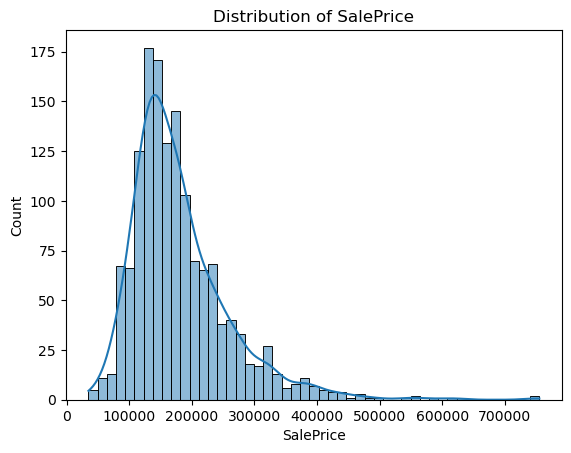

In [6]:
sns.histplot(train_data['SalePrice'], kde=True)
plt.title("Distribution of SalePrice")
plt.show()

C:\Users\owner\AppData\Local\Temp\ipykernel_14024\487045263.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_data.corr()


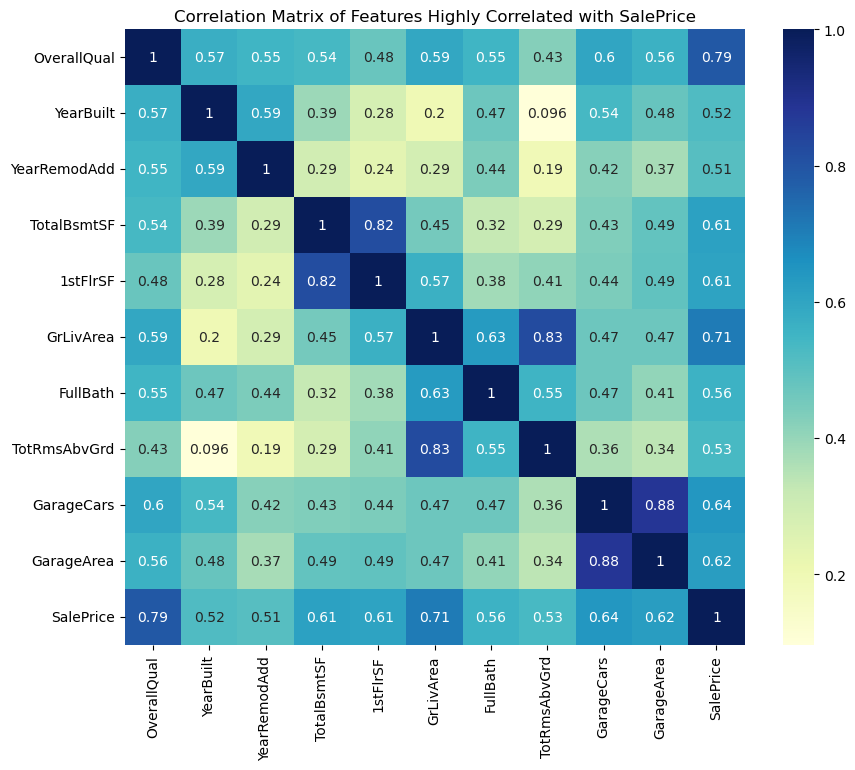

In [7]:
corr_matrix = train_data.corr()
high_corr_features = corr_matrix.index[abs(corr_matrix["SalePrice"]) > 0.5]
plt.figure(figsize=(10, 8))
sns.heatmap(train_data[high_corr_features].corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Matrix of Features Highly Correlated with SalePrice")
plt.show()

In [8]:
X = train_data.drop(['Id', 'SalePrice'], axis=1)
y = train_data['SalePrice']
X_test = test_data.drop(['Id'], axis=1)

In [9]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [14]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


In [15]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [32]:
models = {
    'Linear Regression': Pipeline(steps=[('preprocessor', preprocessor),
                                         ('model', LinearRegression())]),
    
    'Lasso Regression': Pipeline(steps=[('preprocessor', preprocessor),
                                        ('model', Lasso(alpha=0.1))]),
    
    'Random Forest': Pipeline(steps=[('preprocessor', preprocessor),
                                     ('model', RandomForestRegressor(n_estimators=100, random_state=42))]),
    
    'XGBoost': Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))])
}

In [33]:
model_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_valid_pred = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
    model_scores[name] = rmse
    print(f"{name} Validation RMSE: {rmse}")


Linear Regression Validation RMSE: 29448.304092507973


C:\Users\owner\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94230310172.50052, tolerance: 696659484.3571945
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso Regression Validation RMSE: 28329.80560145961
Random Forest Validation RMSE: 28619.934033252557
XGBoost Validation RMSE: 26200.829919193737


In [34]:
best_model_name = min(model_scores, key=model_scores.get)
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name} with RMSE {model_scores[best_model_name]}")



Best model: XGBoost with RMSE 26200.829919193737


In [35]:
best_model.fit(X, y)
test_preds = best_model.predict(X_test)

In [17]:
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', Lasso(max_iter=10000, random_state=42))])

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
param_grid = {'model__alpha': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


C:\Users\owner\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73655989277.67648, tolerance: 537415025.1745833
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\owner\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35765315460.6718, tolerance: 572016182.2224233
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\owner\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68468229398.50241, tolerance: 525605188.80204767
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\owner\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:5

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2...
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                                       ('model',
                                        Lasso(max_iter=10000,
                                              random_state=42))]),
             param_grid={'model__alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [20]:
best_model = grid_search.best_estimator_
print("Best Lasso Alpha:", grid_search.best_params_['model__alpha'])

Best Lasso Alpha: 100


In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
y_valid_pred = best_model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print("Validation RMSE:", rmse)

Validation RMSE: 28328.300062099876


In [36]:
test_preds = best_model.predict(X_test)

In [38]:
submission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': test_preds})
submission.to_csv('submission_house_prices1.csv', index=False)